<a href="https://colab.research.google.com/github/jensbaetens-odisee/BVI/blob/main/RecurrenteNeuraleNetwerken.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text processing

In het vorige vak hebben we manueel gewerkt met tekstuele data en een aantal stappen manueel gedaan.
Deze stappen waren onder andere:
* Tokenizing
* Leestekens verwijderen
* Omzetten naar lowercase
* Stemming
* Stopwoorden verwijderen
* ...

In deze stappen bekwamen we een bag of words. Dat is een vector-voorstelling van de tekst die bijhield hoe vaak elk woord van de woordenboek voorkwam in de tekst.
Het concept van vaak kan een geheel getal zijn maar ook een frequentie op basis van hoe vaak het woord in het algemeen voorkomt in de hele dataset (tf-idf).
Met deze vector hebben we dan ML-modellen getrained.

Om te werken met text vectorization zijn er twee belangrijke lagen binnen tensorflow:
* TextVectorization
* Embedding layer

# Text vectorization

De [Text Vectorization Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) is de basis laag die een hele reeks van de stappen die we vorig jaar manueel gedaan hebben, gaat doen voor ons.
Deze laag zet een batch van strings (1 example = 1 string) om naar een lijst van token indices.
De bedoeling van deze layer is om met meerdere woorden tegelijkertijd te werken, niet met tekstuele klasses (hiervoor gebruik je beter de StringLookupLayer)

Deze laag voert de volgende stappen uit:
* Standaardizeren van elk voorbeeldstring (leestekens verwijderen, lowercase, ...). Dit kan je ook zelf instellen door een functie mee te geven/
* tokenizing
* Eventueel opstellen van n-grams
* Elk token naar een index omzetten
* indexes van elk voorbeeld omzetten naar een vector van ints (sparse) of floats (dense)

Het is duidelijk dat de woordenboek die gebruikt wordt voor dit soort problemen heel belangrijk is.
Deze woordenboek/vocabulary kan ofwel meegegeven worden bij de constructie van de laag of geleerd worden uit de dataset met de **.adapt()** functie

In [ ]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

text_dataset = tf.data.Dataset.from_tensor_slices(["hello world", "this is a test"])
max_features = 5000  # Maximum vocab size.
max_len = 4  # Sequence length to pad the outputs to. (maximum length of a sentence that can be expected)

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(text_dataset.batch(64))   # leer de woordenboek op basis van de dataset
vectorize_layer.get_vocabulary()

['', '[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']

In [ ]:
# int output mode
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: No a test"]]
model.predict(input_data)

1/1 [==============================] - 0s 156ms/step


array([[5, 3, 7, 1],
       [1, 1, 7, 4]])

Let er hierbij op dat de output_sequence_length een belangrijke parameter is.
Deze parameter bepaald de maximale lengte van een zin die verwerkt wordt.
Van zinnen die langer zijn dan dit aantal woorden wordt het einde niet meer in rekening genomen.

In [ ]:
# int output mode
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: No a a a a a a test"]]
model.predict(input_data)

1/1 [==============================] - 0s 69ms/step


array([[5, 3, 7, 1],
       [1, 1, 7, 7]])

In [ ]:
# one hot
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='multi_hot')

vectorize_layer.adapt(text_dataset.batch(64))   # leer de woordenboek op basis van de dataset
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: a a test"]]
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 108ms/step


array([[1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 1.]], dtype=float32)

In [ ]:
# count
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='count')

vectorize_layer.adapt(text_dataset.batch(64))   # leer de woordenboek op basis van de dataset
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: a a test"]]
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 77ms/step


array([[1., 0., 1., 0., 1., 0., 1.],
       [1., 0., 0., 1., 0., 0., 2.]], dtype=float32)

In [ ]:
# tf-idf
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='tf_idf')

vectorize_layer.adapt(text_dataset.batch(64))   # leer de woordenboek op basis van de dataset
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: a a test"]]
model.predict(input_data)

['[UNK]', 'world', 'this', 'test', 'is', 'hello', 'a']
1/1 [==============================] - 0s 92ms/step


array([[0.6931472, 0.       , 0.6931472, 0.       , 0.6931472, 0.       ,
        0.6931472],
       [0.6931472, 0.       , 0.       , 0.6931472, 0.       , 0.       ,
        1.3862944]], dtype=float32)

De tweede optie was om te werken met een reeds bestaande woordenboek.
Een voorbeeld hiervan zie je in de cell hieronder.
Merk op dat je hierbij de adapt functie niet nodig hebt omdat je reeds een woordenboek hebt en er dus niet door de dataset moet gegaan worden.

In [ ]:
vocab_data = ["hello", "world", "test", "a"]
max_len = 5  # Sequence length to pad the outputs to.

# Create the layer, passing the vocab directly. You can also pass the
# vocabulary arg a path to a file containing one vocabulary word per
# line.
vectorize_layer = tf.keras.layers.TextVectorization(
 max_tokens=max_features,
 output_mode='int',
 output_sequence_length=max_len,
 vocabulary=vocab_data)

# Because we've passed the vocabulary directly, we don't need to adapt
# the layer - the vocabulary is already set. The vocabulary contains the
# padding token ('') and OOV token ('[UNK]') as well as the passed
# tokens.
print(vectorize_layer.get_vocabulary())

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
input_data = [["is this a task?"], ["JENS: a a test"]]
model.predict(input_data)

['', '[UNK]', 'hello', 'world', 'test', 'a']
1/1 [==============================] - 0s 64ms/step


array([[1, 1, 5, 1, 0],
       [1, 5, 5, 4, 0]])

# Embedding layer

Het nadeel van een bag-of-words representatie is dat (vooral als je werkt met one-hot, count, tf_idf voorstellingen) je heel snel een heel groot aantal features hebt.
Voor deze voorstellingen heb je namelijk een vector van een lengte gelijk aan het aantal woorden in je taal.
Als we dan proberen te werken met de Engelse taal zijn er momenteel een 170.000 actieve woorden en in het Nederlands kan dit zelfs oplopen tot 350.000 woorden.
Als we vectors van deze lengte doorheen een neuraal netwerk proberen te sturen dan gaat het aantal gewichten gemakkelijk te groot zijn om een efficient, goed werkend model te trainen.

De embedding layer biedt een oplossing voor dit probleem door deze heel grote vectors om te zetten naar een een kleinere vector.
Dit wordt op een bepaalde manier gedaan om zoveel mogelijk informatie te behouden en om ervoor te zorgen dat woorden/zinnen met een gelijkaardige betekenis leiden tot een vector die gelijkaardig is.
Dit laatste wordt gedaan door de laag te trainen.
Dit kan je zien met behulp van onderstaand voorbeeld.

In [ ]:
import numpy as np

# Define 10 restaurant reviews
reviews =[
          'Never coming back!',
          'horrible service',
          'rude waitress',
          'cold food',
          'horrible food!',
          'awesome',
          'awesome services!',
          'rocks',
          'poor work',
          'couldn\'t have done better'
]
#Define labels
labels = np.array([1,1,1,1,1,0,0,0,0,0])
max_len = 4

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(reviews)   # leer de woordenboek op basis van de dataset
vocabulary = vectorize_layer.get_vocabulary()
print(vocabulary)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# embedding layer
embedding = tf.keras.layers.Embedding(input_dim=len(vocabulary), output_dim=8, input_length=max_len)
model.add(embedding)

# add output layer for training embedded layer # doe dit later, bekijk eerst de output van enkel embedded layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation = "sigmoid"))

# dense layer for classification
result = model.predict(reviews)
print(result)
print(result.shape)     # shape is 10x4x8 -> aantal inputs, max aantal woorden per input, output_dim

['', '[UNK]', 'horrible', 'food', 'awesome', 'work', 'waitress', 'services', 'service', 'rude', 'rocks', 'poor', 'never', 'have', 'done', 'couldnt', 'coming', 'cold', 'better', 'back']
1/1 [==============================] - 0s 145ms/step
[[0.5078414 ]
 [0.5161677 ]
 [0.51123446]
 [0.50942713]
 [0.5203516 ]
 [0.49736577]
 [0.50316507]
 [0.50550526]
 [0.5092778 ]
 [0.48765486]]
(10, 1)


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.fit(np.array(reviews),labels,epochs=100,verbose=0)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# embedding layer
model.add(embedding)

results = model.predict(reviews)

print(results.shape)
print(results[1])
print(results[2])

# beide inputs zijn twee woorden dus 3 en 4 zijn steeds gelijk
# het eerste woord is telkens een scheldwoord en deze twee lijken sterk op elkaar

#als je dit vergelijkt met een positieve review, dan zie je dat de waarden van het positieve woord significant anders zijn
print(results[5])

1/1 [==============================] - 0s 68ms/step
(10, 4, 8)
[[ 0.11819981  0.14015433  0.14422368 -0.09170795 -0.08323083  0.14705235
  -0.12157824  0.10131516]
 [ 0.09520719  0.10605373 -0.1029783   0.08237616 -0.1447986   0.11741444
   0.06761342  0.13609658]
 [-0.04339129 -0.08040146  0.11974107 -0.13479225  0.13258012 -0.14281917
  -0.0644341  -0.07649398]
 [-0.04339129 -0.08040146  0.11974107 -0.13479225  0.13258012 -0.14281917
  -0.0644341  -0.07649398]]
[[ 0.10522451  0.08384308  0.08402552 -0.09902949 -0.09694962  0.09773412
  -0.07572588  0.14995936]
 [ 0.11996499  0.14348271 -0.085211    0.10243021 -0.09561113  0.10462397
   0.11132763  0.06234408]
 [-0.04339129 -0.08040146  0.11974107 -0.13479225  0.13258012 -0.14281917
  -0.0644341  -0.07649398]
 [-0.04339129 -0.08040146  0.11974107 -0.13479225  0.13258012 -0.14281917
  -0.0644341  -0.07649398]]
[[-0.11999251 -0.10946413 -0.10729409  0.10322052  0.14436275 -0.10495854
   0.07448047 -0.13651806]
 [-0.04339129 -0.08040146 

Het trainen van deze embedding layers is mogelijk maar dit kan heel snel heel complex worden omdat je hiervoor juist wel moet werken met deze grootte tensors.
Dit kan snel je pc overbelasten of te veel van je RAM geheugen innemen.
Gelukkig is het mogelijk om ook te werken met pre-trained embedded layers.
Hoe je dit doet, kan je [hier](https://keras.io/examples/nlp/pretrained_word_embeddings/#load-pretrained-word-embeddings) lezen maar een snapshot zie je in onderstaande code:

In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import zipfile

od.download("http://nlp.stanford.edu/data/glove.6B.zip") # let op, dit is bijna 1 gb

862183424it [02:43, 5273989.21it/s]                               


In [ ]:
with zipfile.ZipFile("glove.6B.zip") as zf:
    zf.extractall("./pretrained")

In [ ]:
path_to_glove_file = "./pretrained/glove.6B.50d.txt"

embeddings_index = {}
with open(path_to_glove_file, encoding="utf-8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18 words (2 misses)


In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,        # belangrijk -> niet opnieuw aanpassen want reeds getrained
)

model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# embedding layer
model.add(embedding_layer)
results = model.predict(reviews)
print(results)
print(results.shape)

1/1 [==============================] - 0s 63ms/step
[[[ 0.095387  -0.16865   -0.11514   ... -0.42103   -0.53817    0.13738  ]
  [ 0.2169     0.010103   0.20451   ...  0.047386  -0.018309  -0.014132 ]
  [ 0.0046218 -0.25678    0.3532    ... -0.80837   -0.33017   -0.62638  ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[ 0.3614    -0.55138   -0.70054   ...  0.23911    0.60709    0.44516  ]
  [ 0.13409    0.68926    0.45086   ...  0.29695   -0.006097   0.94897  ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 [[-0.4129    -0.37602   -0.99697   ...  0.57652    0.78847    1.4029   ]
  [-0.071998   0.14877   -0.97656   ... -0.80378    0.63032    0.97174  ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]
  [ 0.         0.         0.        ...  0.         0.         0.       ]]

 ...

 [[-0.13424    0.25425    0.39907   ... -0.7476 

# Recurrente Neurale Netwerken

Zoals in de les besproken zijn recurrente neurale netwerken een type van neurale netwerken waarbij er een bepaalde state bijgehouden wordt
die doorgegeven wordt doorheen de tijd.
Dit wil dus zeggen dat we de woorden/n-grammen 1 voor 1 aan het neuraal netwerk doorgeven (ook als sequentie genoemd).
De output is dan ook een sequentie dus is het belangrijk om deze output bij te houden doorheen de tijd.

De bedoeling van deze structuren is om geheugen in het netwerk te introduceren.
Hierdoor is het mogelijk om complexere verbanden te detecteren doorheen de tijd in bijvoorbeeld geschreven tekst, audio of video.
Om dit geheugen toe te voegen in neurale netwerken kunnen de volgende lagen gebruikt worden:
* RNN
* LSTM
* GRU

RNN is de basis structuur. Het voordeel van deze structuur is dat het de eenvoudigste is maar het geheugen dat hierdoor voorzien word is maar kort.
Deze laag heeft snel problemen door het vanishing gradient problem.
De LSTM en GRU lagen zijn complexer en werken met gates om te bepalen welke informatie bijgehouden wordt in de state en welke genegeerd wordt.
Hierdoor kunnen deze lagen een langer geheugen hebben.
De benodigde rekenkracht voor deze lagen licht wel een stuk hoger.
Ook is er een hogere kans dat deze lagen overfitten en door de complexere structuur is het toevoegen van dropout ook complexer.

Er zijn 4 types netwerk architecturen die mogelijk zijn bij het werken met recurrente neurale netwerken, namelijk:
* One-to-One
* Many-to-One
* One-to-Many
* Many-to-Many

In de rest van deze notebook worden deze 4 architecturen bestudeerd. Op het einde bekijken we ook de resultaten van een populair pre-trained netwerk, namelijk het BERT netwerk, om te werken met tekstuele data.

## One-to-One

Eerst gaan we kijken naar de one-to-one architectuur.
Dit is eigenlijk overeenkomstig met alles wat we reeds gedaan hebben want dit is dat je 1 input geeft en je krijgt 1 output. Er is geen state die doorgegeven wordt naar de volgende tijdstappen.

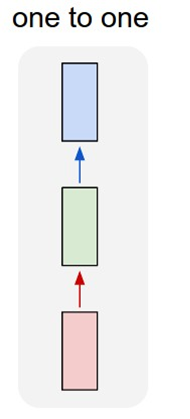

## Many-to-One

Een tweede architectuur waar wel sprake is van recurrente verbindingen is de many-to-one architectuur.
Dit is de typische architectuur voor classificatie van teksten.
Hierbij geef je woord per woord door wat je input is en op het einde heb je 1 output, namelijk de klasse van de tekst.

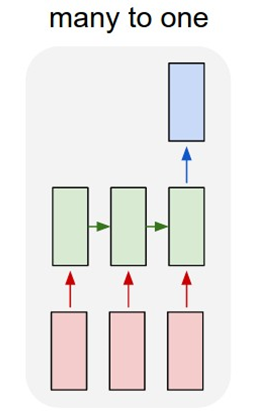

In de code hieronder staat er een voorbeeld om dit soort problemen op te lossen voor fake news classificatie.

In [ ]:
od.download("https://www.kaggle.com/datasets/stevenpeutz/misinformation-fake-news-text-dataset-79k")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jensbaetensodisee
Your Kaggle Key: ··········


100%|██████████| 84.6M/84.6M [00:00<00:00, 114MB/s]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

df_fake = pd.read_csv("./misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_FAKE.csv")
df_fake["label"] = 1
df_true = pd.read_csv("./misinformation-fake-news-text-dataset-79k/DataSet_Misinfo_TRUE.csv")
df_true["label"] = 0
df = pd.concat([df_fake, df_true])[["text", "label"]]
df = df.dropna()

# note - alle fake news staat eerst, daarna het echte nieuws --> hiermee moet rekening gehouden worden bij het splitsen
display(df.head())

max_text_length = df.text.str.len().max()
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train = tf.convert_to_tensor(X_train.to_list())
X_test =  tf.convert_to_tensor(X_test.to_list())
y_train =  tf.convert_to_tensor(y_train.to_list())
y_test =  tf.convert_to_tensor(y_test.to_list())

,text,label
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [ ]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 34974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [ ]:
# text vectorization
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

vectorize_layer.adapt(X_train)    # batching for increasing performance
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

# embedding
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,        # belangrijk -> niet opnieuw aanpassen want reeds getrained
)

Vocabulary size: 4000


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    tf.keras.layers.SimpleRNN(units=100),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

NameError: ignored

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Epoch 1/3
983/983 [==============================] - 8s 8ms/step - loss: 0.5036 - accuracy: 0.7537
Epoch 2/3
983/983 [==============================] - 8s 8ms/step - loss: 0.4410 - accuracy: 0.7901
Epoch 3/3
983/983 [==============================] - 8s 8ms/step - loss: 0.4145 - accuracy: 0.8040
[0.42230862379074097, 0.7996564507484436]


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    tf.keras.layers.LSTM(units=100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 4)                0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 4, 50)             250100    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 310,601
Trainable params: 60,501
Non-trainable params: 250,100
_________________________________________________________________
None
Epoch 1/3
983/983 [==============================] - 14s 12ms/step - loss: 0.5128 - accuracy: 0.7452
Ep

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer,
    tf.keras.layers.GRU(units=100, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=3, batch_size=64)
scores = model.evaluate(X_test, y_test, verbose=0)
print(scores)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_6 (TextV  (None, 4)                0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 4, 50)             250100    
                                                                 
 gru (GRU)                   (None, 100)               45600     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 295,801
Trainable params: 45,701
Non-trainable params: 250,100
_________________________________________________________________
None
Epoch 1/3
983/983 [==============================] - 14s 12ms/step - loss: 0.5147 - accuracy: 0.7456
Ep

## Many-to-many



Dit soort architecturen heeft een sequentie van woorden als input en ook een sequentie als output.
Een typisch voorbeeld hiervan is het maken van een model dat tekst genereert op basis van een begintekst.

De code voor het voorbeeld bestaat uit de volgende stappen:
* Maken van sequenties van woorden en volgende woorden
* De woorden in deze sequenties omzetten naar embeddings
* Opbouwen van een model
* Trainen van het model
* Experimenteren met het model.

**1. Maken van de sequenties**

In de eerste stap gaan we tekst inladen en de zinnen omzetten naar sequenties en de woorden die erachter komen.
De data die we hiervoor gaan gebruiken zijn de artikels uit de vorige dataset met artikels.
Dit kan je doen door middel van de volgende code:


In [ ]:
import numpy as np
import tensorflow as tf

sequenties = []
next_words = []
sequence_length=30
sequence_step=1
max_features = 4000

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int')
vectorize_layer.adapt(X_train)

def extract_input_data(row):
  article = row.text
  tokens = vectorize_layer(article)
  for i in range(0, len(tokens)-sequence_length, sequence_step):
    sequenties.append(tokens[i: i+sequence_length])
    next_words.append(tokens[i+sequence_length])

df.sample(n=200).apply(extract_input_data, axis=1)

print("number of sequences", len(sequenties))
print("number of words", len(next_words))

number of sequences 87923
number of words 87923


In [ ]:
sequenties[0]

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([   1, 3801,    1,  739,    1,   73,  400,    1,  409,    1,  172,
          6, 1313,    1,    9,  355,    7,    2,    1,  668,    2,    1,
          1,  672, 1156,  614, 1680, 1069,    1,    1])>

**2. Woorden omzetten naar embeddings**

In [ ]:
# embedding
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,        # belangrijk -> niet opnieuw aanpassen want reeds getrained
)

X = np.zeros((len(sequenties), sequence_length, embedding_dim), dtype=np.bool)
y = np.zeros((len(sequenties), embedding_dim), dtype=np.bool)

for i in range(0, len(sequenties)):
  if i%1000 == 0:
    print(i)
  for j in range(sequence_length):
    X[i,j] = embedding_layer(sequenties[i][j])
  y[i] = embedding_layer(next_words[i])

Converted 3897 words (103 misses)
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000


**3. Opstellen van een model**

Hierbij maken we gebruik van een nieuwe laag.
Namelijk de [**Bidirectional**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/) laag.
Deze laag maakt het mogelijk om de sequentie zowel voorwaarts als achterwaarts te bestuderen.
Dit zorgt ervoor dat bepaalde tijdsreeksen zoals tekst veel beter geanalyseerd en gemodelleerd kunnnen worden door een RNN.
Dit gebeurd in onderstaande code

In [ ]:
num_neurons=150

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(num_neurons, activation="relu"),input_shape=(sequence_length, embedding_dim)))
model.add(tf.keras.layers.Dense(embedding_dim))

model.compile(loss='mse', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 300)              241200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 50)                15050     
                                                                 
Total params: 256,250
Trainable params: 256,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model(tf.expand_dims(X[0],0))

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[-0.26766533,  0.20878775, -0.14674123,  0.51369286, -0.30343708,
         0.5639777 ,  0.08738301, -0.00352803,  0.36087194,  0.16123   ,
         0.06881865, -0.01617968,  0.09604689, -0.25714406,  0.06888981,
        -0.09767964, -0.05931208,  0.15136728, -0.4251202 , -0.10957611,
        -0.01195525,  0.00141792,  0.03537942,  0.07809545, -0.47946268,
        -0.02608854, -0.14566112, -0.14182928, -0.44753397,  0.29456908,
        -0.10165446, -0.28152043, -0.08618772,  0.18648405,  0.00418301,
         0.00399116, -0.04382921,  0.17616312, -0.09215686, -0.20888965,
        -0.00201762, -0.1333602 ,  0.06807059, -0.33696002, -0.00363174,
        -0.19267845, -0.20316286, -0.04768033,  0.27892205, -0.3388823 ]],
      dtype=float32)>

**4. Trainen van een model**

In [ ]:
batch_size = 32 # minibatch size
num_epochs = 5 # number of epochs

#fit the model
history = model.fit(X, y,
                 batch_size=batch_size,
                 shuffle=True,
                 epochs=num_epochs,
                 validation_split=0.1)

#save the model
model.save('text_generator.h5')

Epoch 1/5
2473/2473 [==============================] - 180s 73ms/step - loss: 0.1362 - val_loss: 0.1267
Epoch 2/5
2473/2473 [==============================] - 153s 62ms/step - loss: 0.1358 - val_loss: 0.1253
Epoch 3/5
2473/2473 [==============================] - 141s 57ms/step - loss: 0.1357 - val_loss: 0.1274
Epoch 4/5
2473/2473 [==============================] - 140s 56ms/step - loss: 0.1356 - val_loss: 0.1274
Epoch 5/5
2473/2473 [==============================] - 141s 57ms/step - loss: 0.1356 - val_loss: 0.1275


**5. Genereren van tekst**

Wanneer we nu een beginsequentie aan het model geven, dan kan het volgende woord voorspeld worden.
Dit woord kan dan toegevoegd worden aan de sequentie en het volgende woord kan voorspeld worden.
Door dit te herhalen kan je een tekst van willekeurige lengte voorspellen.

Een probleem hierbij is nog dat we embeddings voorspellen.
Dit is een vector voorstelling van elk woord.
Deze vectors moeten nog terug geconverteerd worden naar een woord.

Deze conversies worden uitgevoerd door onderstaande code:

In [ ]:
test = "eric"
test_index = vectorize_layer(test)
test_embedding = embedding_layer(test_index)

print("Origineel woord", test)
print("index van origineel", test_index)
print("Embedding van origineel", test_embedding)
print("Shape embedding", test_embedding.shape)

# de embedding layer berekent eigenlijk de vector zoals een neuraal netwerk.
# we kunnen hiervan de omgeerde berekenen als volgt: (source: https://stackoverflow.com/questions/45773660/reverse-word-embeddings-in-keras-python)
voc_values = tf.linalg.matmul(test_embedding,tf.linalg.pinv(embedding_layer.weights[0]))
index = np.argmax(voc_values)
test_reverted_word = vectorize_layer.get_vocabulary()[index]

print("index reversed word", index)
print("reversed word", test_reverted_word)

Origineel woord eric
index van origineel tf.Tensor([1870], shape=(1,), dtype=int64)
Embedding van origineel tf.Tensor(
[[-0.71378   0.6021   -0.18039   0.055713  0.26257   0.47558  -1.4423
  -0.21101  -0.28674  -0.29056   0.50427   0.6679   -1.2103   -0.35219
   0.678    -0.079145  0.90001  -1.4222   -0.79457   0.19777  -0.34857
  -0.13766   0.092349 -0.098746 -0.37293  -0.86464   0.25728  -0.36503
  -0.097986 -0.60648   0.96637   0.25977   0.21768  -0.44957  -0.26333
  -0.20539   0.30741   0.09092   0.54008   1.1054    0.38505   1.2016
  -0.68476  -0.68771   0.81133  -0.89632   0.41665  -0.42198  -0.77933
   1.4481  ]], shape=(1, 50), dtype=float32)
Shape embedding (1, 50)
index reversed word 1870
reversed word eric


In [ ]:
def reverse_embedding(word_embeddings):
  voc_values = tf.linalg.matmul(word_embeddings,tf.linalg.pinv(embedding_layer.weights[0]))
  index = np.argmax(voc_values)
  test_reverted_word = vectorize_layer.get_vocabulary()[index]

  return test_reverted_word

Met bovenstaande functie kunnen we dan embeddings gaan voorspellen en terug omzetten naar tekst.
Dit gebeurd in onderstaande code.

In [ ]:
num_words_to_generate = 1
generated = ''
sentence = []

seed_sentence = "The winner of the elections is going to be "
generated = seed_sentence
seed = embedding_layer(vectorize_layer(seed_sentence))
seed_X = np.zeros((1, sequence_length, embedding_dim))
seed_X[0, -len(seed):] = seed

# make prediction
for i in range(num_words_to_generate):
  preds = model.predict(seed_X, verbose=0)
  # print(preds)

  # save predicted word
  next_word = reverse_embedding(preds)
  generated += ' ' + next_word
  sentence.append(next_word)

  # shift sequence
  tmp = seed_X.copy()
  seed_X[0,:-1] = seed_X[0, 1:]
  seed_X[0, -1] = preds
  difference = ((tmp-seed_X) **2).sum()
  print(difference)

print("Result is:")
print(seed_sentence, ' '.join(sentence))

222.32843796049923
Result is:
The winner of the elections is going to be  hasn


## One-to-many

In dit soort van problemen beginnen we van 1 enkele input waarden die we een aantal keer hergebruiken om zo meerdere outputs te genereren.
Dit kan je zien in onderstaande figuur.

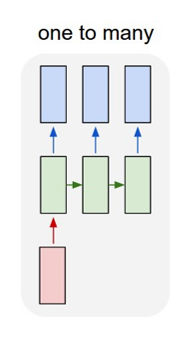

Als voorbeeld hiervan gaan we kijken of de volgende 5 getallen van een getal kunnen voorspeld worden aan de hand van recurrent neuraal netwerk.

De eerste stap in dit voorbeeldje moeten we dan deze experimentele dataset aanmaken.
Dit kan als volgt:

In [ ]:
import tensorflow as tf
import numpy as np

max_int = 100
num_samples = 100
output_length = 5

X = np.random.randint(max_int, size=(num_samples))
X = X.astype('float')
Y = np.zeros((num_samples, output_length))

print(Y.shape)

for i in range(num_samples):
  Y_element = np.zeros(output_length)
  for j in range(output_length):
    Y_element[j] = X[i]+j+1
  Y[i] = Y_element

print(X)
print(Y)

(100, 5)
[38. 50. 99. 48. 57. 45. 31.  8. 57. 66. 44. 86. 95. 50. 55. 21. 45. 80.
 94.  6. 67. 21. 62. 20. 85. 20. 12. 10. 35. 69. 61. 25. 10. 20. 70.  5.
 57. 23. 65. 71. 47. 74. 23. 37. 31. 96.  1. 18. 14. 25. 54. 69. 59. 62.
 94.  3. 53. 36.  2. 63. 46. 11.  1. 77. 49. 41. 44. 35. 66. 60. 71. 83.
 15.  7. 38.  1. 23. 36. 98. 56. 17. 36. 30. 11. 69. 79. 64. 28. 58. 87.
 55.  0.  6. 79. 65. 64. 30. 13. 65.  2.]
[[ 39.  40.  41.  42.  43.]
 [ 51.  52.  53.  54.  55.]
 [100. 101. 102. 103. 104.]
 [ 49.  50.  51.  52.  53.]
 [ 58.  59.  60.  61.  62.]
 [ 46.  47.  48.  49.  50.]
 [ 32.  33.  34.  35.  36.]
 [  9.  10.  11.  12.  13.]
 [ 58.  59.  60.  61.  62.]
 [ 67.  68.  69.  70.  71.]
 [ 45.  46.  47.  48.  49.]
 [ 87.  88.  89.  90.  91.]
 [ 96.  97.  98.  99. 100.]
 [ 51.  52.  53.  54.  55.]
 [ 56.  57.  58.  59.  60.]
 [ 22.  23.  24.  25.  26.]
 [ 46.  47.  48.  49.  50.]
 [ 81.  82.  83.  84.  85.]
 [ 95.  96.  97.  98.  99.]
 [  7.   8.   9.  10.  11.]
 [ 68.  69.  70.  71.  7

Om deze dataset te gebruiken voor een recurrent neuraal netwerk met een one-to-many architectuur moet er laag gebruikt worden die de enkelvoudige input elke tijdsstap van de sequentie aanrijkt aan het neuraal netwerk.
Hiervoor kan je de [RepeatVector layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RepeatVector) gebruiken van tensorflow.

Om de output te berekenen kan je werken op de volledige sequence en voor elke waarde in de sequence iets voorspellen. Het nadeel is hiervoor dat je meer gewichten en neuronen nodig hebt.
Het is ook mogelijk om dezelfde laag uit te voeren op elk entry van de sequence.
Hiervoor heb je de [TimeDistributed layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) nodig om dit uit te voeren.

Een one-to-many model kan bijvoorbeeld als volgt opgebouwd worden.

In [ ]:
model = tf.keras.models.Sequential()
# repeat vector - single input to sequence of 5 samples
model.add(tf.keras.layers.RepeatVector(output_length))

model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))
model.add(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True))

# met de time distributed ga je dezelfde laag op elke tijdsstap uitvoeren
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

model.compile(optimizer='adam', loss='mse')

history = model.fit(tf.expand_dims(X,1), Y, epochs=100, validation_split=0.2, verbose=1, batch_size=3)


Epoch 1/100
27/27 [==============================] - 3s 23ms/step - loss: 1467.7855 - val_loss: 686.9674
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 405.1343 - val_loss: 174.5781
Epoch 3/100
27/27 [==============================] - 0s 11ms/step - loss: 76.3163 - val_loss: 7.5754
Epoch 4/100
27/27 [==============================] - 0s 10ms/step - loss: 8.5264 - val_loss: 5.5205
Epoch 5/100
27/27 [==============================] - 0s 10ms/step - loss: 4.0928 - val_loss: 3.3536
Epoch 6/100
27/27 [==============================] - 0s 10ms/step - loss: 2.5076 - val_loss: 2.1563
Epoch 7/100
27/27 [==============================] - 0s 10ms/step - loss: 1.4769 - val_loss: 1.4806
Epoch 8/100
27/27 [==============================] - 0s 10ms/step - loss: 0.9847 - val_loss: 0.9492
Epoch 9/100
27/27 [==============================] - 0s 11ms/step - loss: 0.6562 - val_loss: 0.7253
Epoch 10/100
27/27 [==============================] - 0s 11ms/step - loss: 0.4932 - val_lo

Voorspellingen kunnen gemaakt worden via onderstaande code

In [ ]:
model(np.array([20]))

<tf.Tensor: shape=(1, 5, 1), dtype=float32, numpy=
array([[[20.952906],
        [22.008167],
        [23.016367],
        [24.008593],
        [25.024391]]], dtype=float32)>

Een typisch voorbeeld hiervan is een AI voor vertalingen uit te voeren.
Dit gaan we dan ook doen in de onderstaande code.
De tutorial waar deze code is op gebaseerd vind je [hier](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

In [ ]:
import pathlib
import numpy as np

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

def load_data(path):
  text = path.read_text(encoding='utf-8')

  lines = text.splitlines()
  pairs = [line.split('\t') for line in lines]

  context = np.array([context for target, context in pairs])    # input
  target = np.array([target for target, context in pairs])      # output

  return target, context

target_raw, context_raw = load_data(path_to_file)
print(context_raw[-1])
print(target_raw[-1])

Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.
If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [ ]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw),)) < 0.8     # selecteer 20% random samples voor validatie

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[is_train], target_raw[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[~is_train], target_raw[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

for example_context_strings, example_target_strings in train_raw.take(1):   # take 1 batch
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Tom ciertamente habla un mont\xc3\xb3n.' b'No hay nadie ac\xc3\xa1.'
 b'Ponle llave a la ventana antes de acostarte.' b'\xc3\x89l es actor.'
 b'Te contactaremos tan pronto averig\xc3\xbcemos cualquier cosa.'], shape=(5,), dtype=string)

tf.Tensor(
[b'Tom certainly talks a lot.' b"There's nobody here."
 b'Lock the window before going to bed.' b'He is an actor.'
 b'As soon as we find out anything, we will contact you.'], shape=(5,), dtype=string)


In [ ]:
!pip install tensorflow_text

In [ ]:
# text vectorization

import tensorflow_text as tf_text

max_vocab_size = 15000

# we willen deze functie gebruiken om een aantal zaken te doen die niet standaard gebeuren.
# bevoorbeeld worden characters met accenten verwijderd en worden [Start] en [End] tokens toegevoegd om het begin en einde van een woord aan te geven
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

spanish_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)              # output van elke image kan een verschillende lengte hebben (geen padding)

spanish_text_processor.adapt(train_raw.map(lambda context, target: context))    # geef enkel de context mee

# Here are the first 10 words from the vocabulary:
print(spanish_text_processor.get_vocabulary()[:10])

english_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

english_text_processor.adapt(train_raw.map(lambda context, target: target))
print(english_text_processor.get_vocabulary()[:10])

['', '[UNK]', '[START]', '[END]', '.', 'que', 'de', 'el', 'a', 'no']
['', '[UNK]', '[START]', '[END]', '.', 'the', 'i', 'to', 'you', 'tom']


In [ ]:
# verwerk de text zodat de string in een lijst met tokens wordt omgezet
# voor de output worden er twee versies berekend, de rij en de rij met 1 verschoven
# dit omdat we steeds de output terug aanbieden als input ook om verder te kunnen bouwen op het laatst gelezen woord

def process_text(input, output):
  input = spanish_text_processor(input).to_tensor()
  output = english_text_processor(output)
  output_in = output[:,:-1].to_tensor()
  output_out = output[:,1:].to_tensor()
  return (input, output_in), output_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

example_tokens = spanish_text_processor(example_context_strings)
example_tokens[:3, :]

[  2  10 146  15  36 222  19  13   9  12]

[  2   9  12 160  33 239  18 134  13  11]
[  9  12 160  33 239  18 134  13  11   3]


<tf.RaggedTensor [[2, 10, 3133, 215, 16, 701, 4, 3], [2, 9, 59, 110, 521, 4, 3],
 [2, 5267, 450, 8, 11, 376, 123, 6, 5103, 4, 3]]>

In [ ]:
def tensor_to_string(tokens):
    context_vocab = np.array(spanish_text_processor.get_vocabulary())
    return ' '.join(context_vocab[tokens.numpy()])

tensor_to_string(example_tokens[0])

'[START] tom ciertamente habla un monton . [END]'

Nu kunnen we een model opstellen om de vertaling uit te voeren.
De structuur van dit model ziet er uit als volgt:

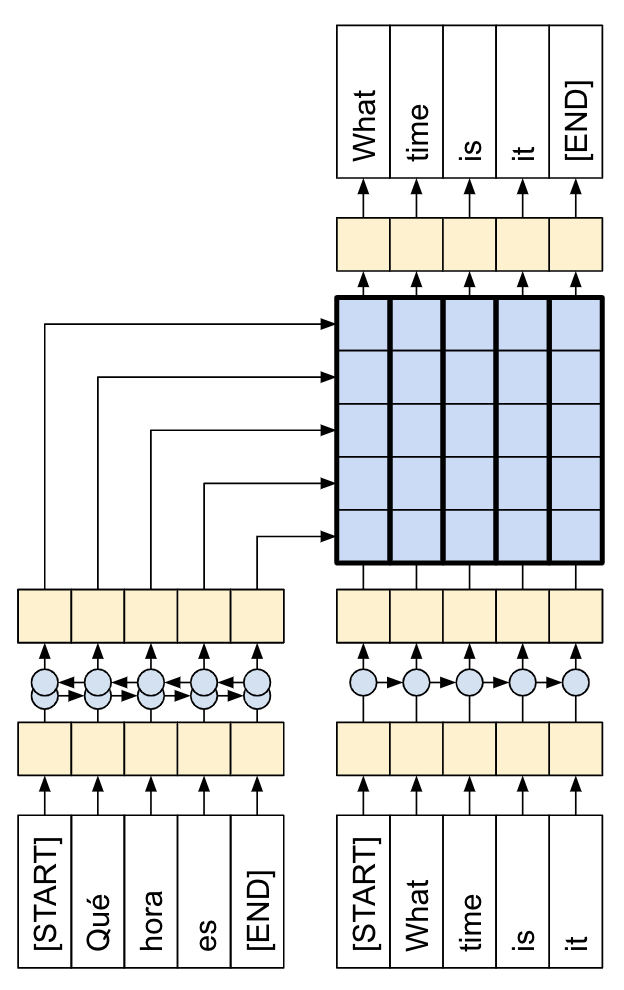

Dit netwerk bestaat uit een aantal delen.
Ten eerste is er het **encoder** gedeelte.
Dit is een bidirectionele RNN om de verbanden in de input te gaan zoeken.
Dit wordt gebruikt als context waaruit de vertaalde zin opgebouwd gaat worden.
Grafisch ziet dit deel er uit als volgt

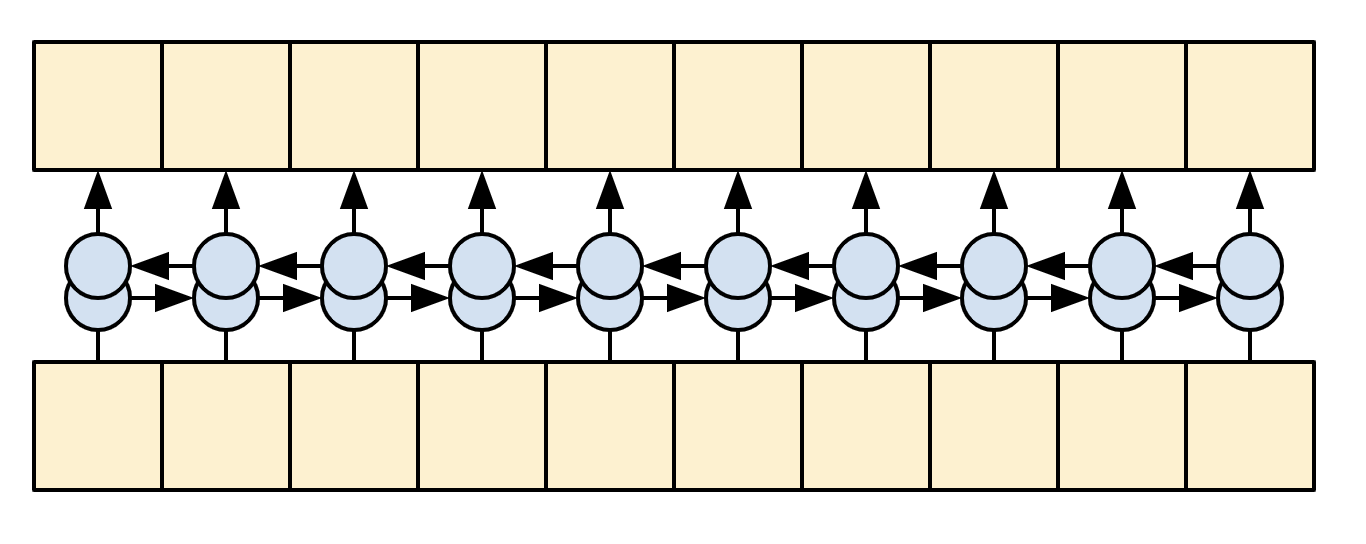

In [ ]:
units = 50

# The embedding layer converts tokens to vectors
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_vocab_size, units, mask_zero=True),
  tf.keras.layers.Bidirectional(
      merge_mode='sum',
      layer=tf.keras.layers.LSTM(units, return_sequences=True))
])

test_encoder = encoder(ex_context_tok)

print(f'Input tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {test_encoder.shape}')

Input tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 50)


Het volgende deel van het netwerk is de zogenaamde **attention** layer.
Het doel van deze laag is om de informatie die de encoder uit de input sequentie gehaald heeft beschikbaar te maken voor de decoder (deze komt later).

Conceptueel gaat deze een gewogen som van de outputs van de encoder.
Het deel van het model dat behoort tot deze layer is het volgende:

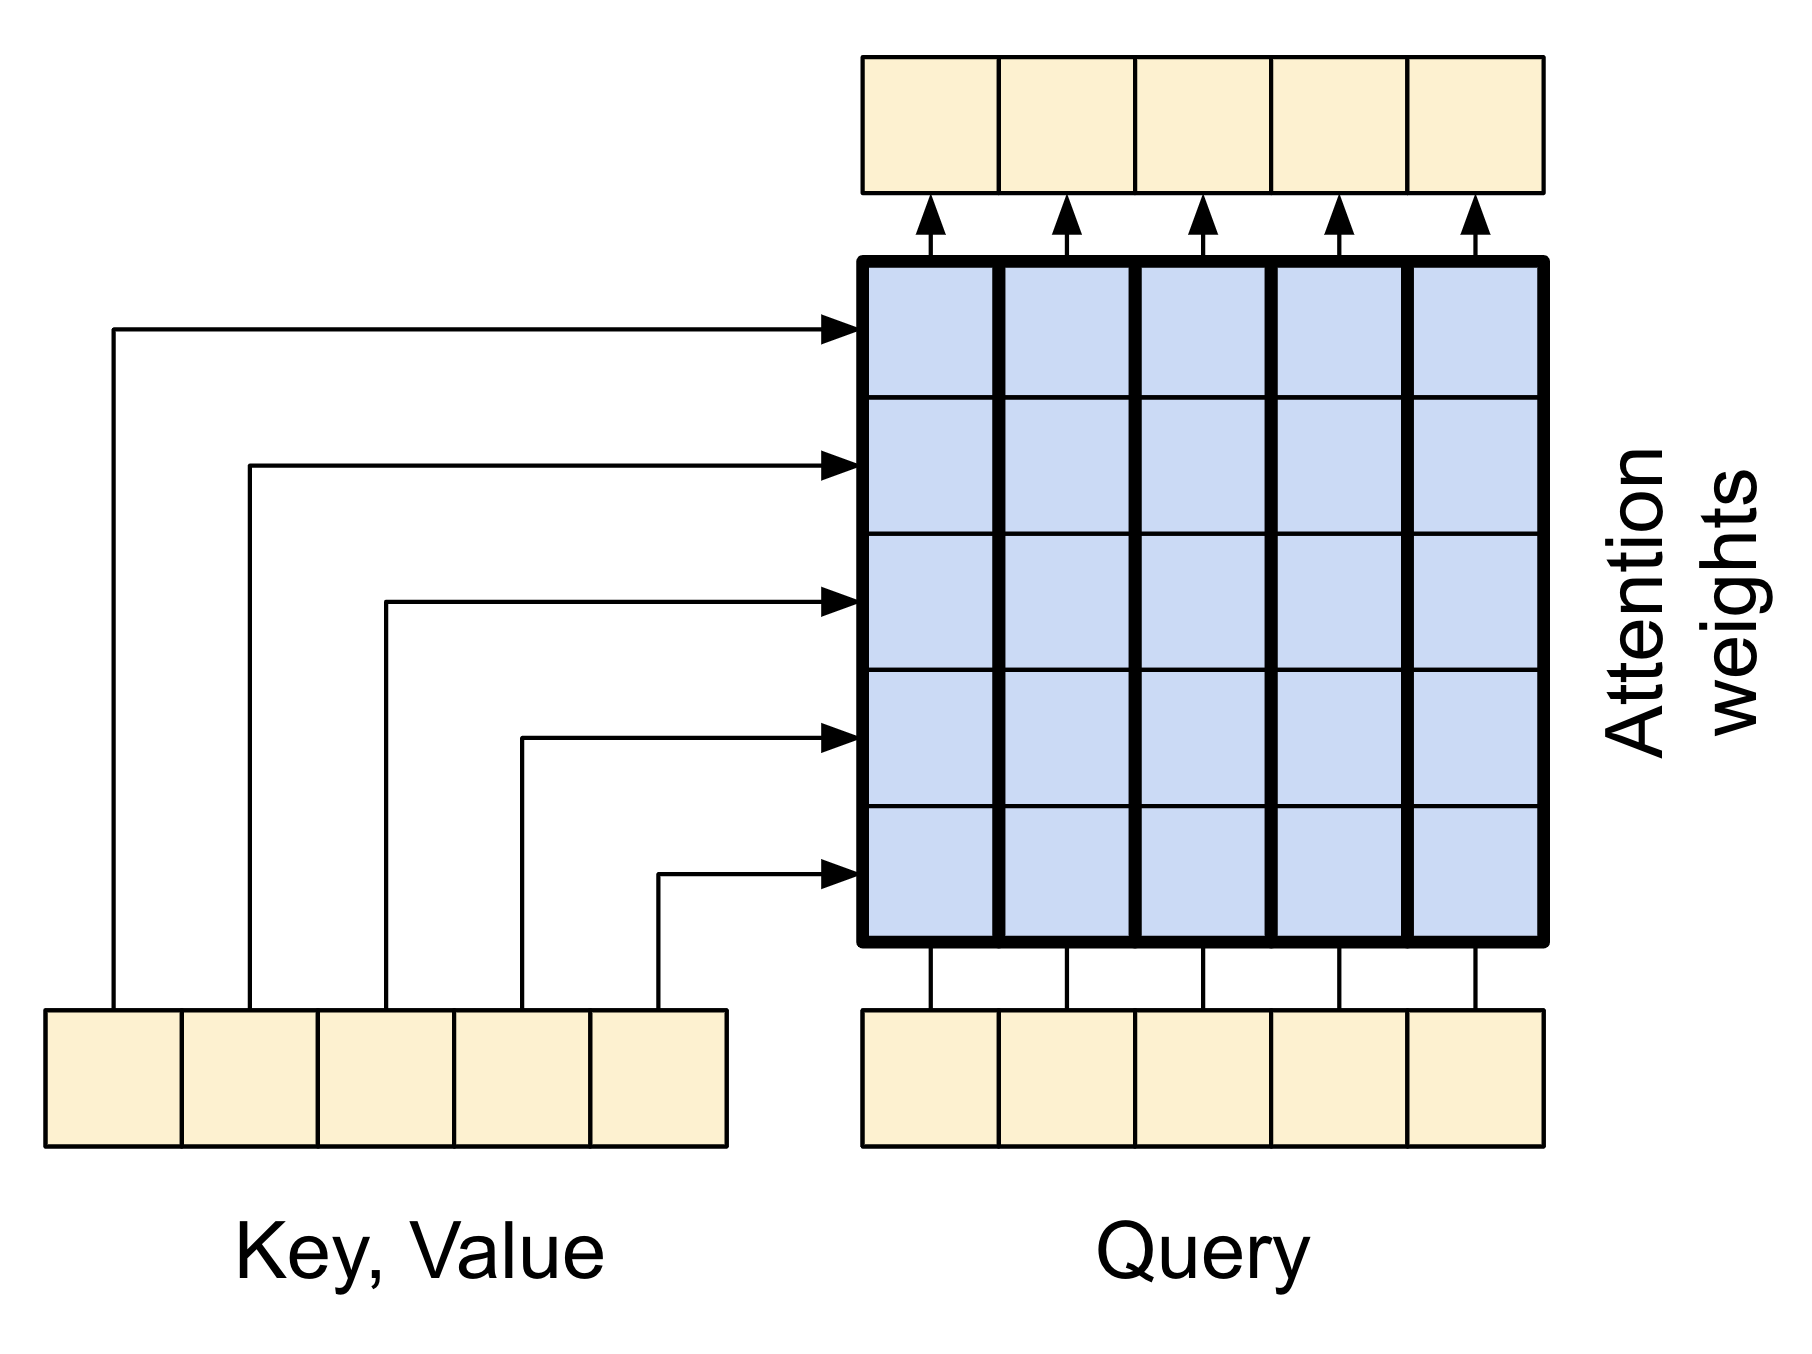

In [ ]:
encoder = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(max_vocab_size, units, mask_zero=True),
  tf.keras.layers.Bidirectional(
      merge_mode='sum',
      layer=tf.keras.layers.LSTM(units, return_sequences=True))
])

## One-to-many

Hiervoor gaan we werken aan een toepassing om beelden te beschrijven.
Hiervoor gaan we [deze dataset](https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions) gebruiken.

Een tutorial voor dit type probleem vind je [hier](https://www.tensorflow.org/tutorials/text/image_captioning).

In dit image captioning netwerk gaan we gebruik maken van het inception model voor het feature extraction gedeelte op de image.
Hierbij gaan we ook gebruik maken van een Attention Layer om


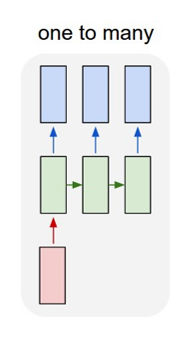

In [ ]:
od.download("https://www.kaggle.com/datasets/aladdinpersson/flickr8kimagescaptions")

In [ ]:
df = pd.read_csv("flickr8kimagescaptions/flickr8k/captions.txt")
df.info()
df.head()

max_length_sentence = int(df.caption.str.len().max())
print("longest sentence contains", max_length_sentence, "words")

In [ ]:
# text vectorization
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_length_sentence)

vectorize_layer.adapt(df.caption)    # batching for increasing performance
print("Vocabulary size:", len(vectorize_layer.get_vocabulary()))

# embedding
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,        # belangrijk -> niet opnieuw aanpassen want reeds getrained
)

output_encoder = tf.keras.models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    embedding_layer
])


In [ ]:
from imageio import imread

# set 100 images aside for validation
num_val_samples = 1000
train_input_imgs = df.image[:-num_val_samples]
train_targets = df.caption[:-num_val_samples]
val_input_imgs = df.image[-num_val_samples:]
val_targets = df.caption[-num_val_samples:]

def convert_to_filepath(filepath):
    return "./flickr8kimagescaptions/flickr8k/images/" + filepath

# maak Sequence om niet alle figuren tegelijkertijd te moeten inladen
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        start_index = idx * self.batch_size
        end_index = min(start_index+batch_size, len(self.x))
        size = end_index - start_index

        batch_x = np.array([imread(convert_to_filepath(self.x[idx])) for idx in range(start_index, end_index)])
        batch_y = np.array([self.y[idx] for idx in range(start_index, end_index)])

        return batch_x, batch_y

batch_size=64
train_gen = DataGenerator(train_input_imgs, train_targets, batch_size)
val_gen = DataGenerator(val_input_imgs, val_targets, batch_size)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imread("./flickr8kimagescaptions/flickr8k/images/1000268201_693b08cb0e.jpg"))

In [ ]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable=False

#base_model.summary()

model = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(299,299),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.RepeatVector(max_length_sentence),    # deze laag zorgt ervoor dat je een aantal keer dezelfde figuur aangeeft aan de inception layer (1 stap per woord)
    tf.keras.layers.SimpleRNN(embedding_dim, return_sequences=True)                   # we gaan de vector horende bij een woord van de embedding layer proberen te voorspellen, deze kan dan terug omgezet worden naar een woord
])

In [ ]:
test_batch_X, test_batch_y = train_gen.__getitem__(0)

single_img_X = test_batch_X[0]
single_img_y = test_batch_y[0]

print(model(tf.expand_dims(single_img_X, 0)))      # dimensies 1 -> 1 example, 199 -> max aantal woorden, 50 -> embedding vector van elk woord
print(output_encoder(tf.expand_dims(single_img_y, 0)))